## Data used in these notebooks: NYC Taxi trips open data

Given hourly historical taxi trips data for NYC, your task is to predict #pickups in next 7 days, per hour and per pickup zone.  <br>

<ul>
<li>Original data source:  <a href="https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page" target="_blank"> https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page</a> </li>
<li>AWS-hosted public source:  <a href="https://registry.opendata.aws/nyc-tlc-trip-records-pds/" target="_blank">https://registry.opendata.aws/nyc-tlc-trip-records-pds/ </a> </li>
<li>AWS managed weather data ingestion as a service that is bundled with Amazon Forecast, aggregated by location and by hour.  Initially only for USA and Europe, but depending on demand, possibly in the future for other global regions. </li>
<li>Data used:  Yellow taxis dates: 2018-12 through 2020-02 to avoid COVID effects </li>
</ul>

 
### Features and cleaning
Note: ~5GB Raw Data has already been cleaned and joined using AWS Glue (tutorials to be created in future). 
<ul>
    <li>Join shape files Latitude, Longitude</li>
    <li>Add Trip duration in minutes</li>
    <li>Drop negative trip distances, 0 fares, 0 passengers, less than 1min trip durations </li>
    <li>Drop 2 unknown zones ['264', '265']
    </ul>

## Step 0:  Set up and install libraries <a class="anchor" id="setup"></a>

In [15]:
# Import standard open libraries
import os
import sys
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import time
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# AWS libraries and initialization
import boto3
import sagemaker

<b>Create a new S3 bucket for this lesson</b>
- The cell below will create a new S3 bucket with name ending in "forecast-demo-taxi"

In [16]:
# create unique S3 bucket for saving your own data
from sagemaker import get_execution_role
sess = sagemaker.Session()
s3_bucket_name = sess.default_bucket()
    
# create prefix for organizing your new bucket
prefix = "nyc-taxi-trips"
print(f"using folder '{prefix}'")

using folder 'nyc-taxi-trips'


## Step 1. Read data <a class="anchor" id="read"></a>

The first thing we're going to do is read the headerless .csv file.  Then we need to identify which columns map to required Amazon Forecast inputs.

<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/nyctaxi_map_fields.png" width="82%">
<br>

<b>In order to use Weather Index, you need a geolocation-type column.</b>  The geolocation-type column connects your locations to geolocations, and can be 5-digit postal code or latitude_longitude.  For more details, see:
<ul>
    <li><a href="https://docs.aws.amazon.com/forecast/latest/dg/weather.html" target="_blank">Link to documentation about geolocations</a></li>
    <li><a href="https://aws.amazon.com/blogs/machine-learning/amazon-forecast-weather-index-automatically-include-local-weather-to-increase-your-forecasting-model-accuracy/" target="_blank">Our Weather blog, which shows UI steps.</a></li>
</ul>

The cell below shows an example reading headerless csv file with lat_lon geolocation column, "pickup_geolocation".  The rest of this notebook writes headerless csv files to be able to use automation.  If you are not planning on using the automation solution, .csv files with headers are allowed.

In [18]:
## Read cleaned, joined, featurized data from Glue ETL processing
df_raw = pd.read_csv("s3://amazon-forecast-samples/data_prep_templates/clean_features.csv"
                          , parse_dates=True
                          , header=None
                          , dtype={0:'str'
                                   , 1: 'str'
                                   , 2: 'str'
                                   , 3:'str'
                                   , 4: 'int32'
                                   , 5: 'float64'
                                   , 6: 'str'
                                   , 7: 'str'
                                   , 8: 'str'}
                          , names=['pulocationid', 'pickup_hourly', 'pickup_day_of_week'
                                   , 'day_hour', 'trip_quantity', 'mean_item_loc_weekday'
                                   , 'pickup_geolocation', 'pickup_borough', 'binned_max_item'])

# drop duplicates
print(df_raw.shape)
df_raw.drop_duplicates(inplace=True)

df_raw['pickup_hourly'] = pd.to_datetime(df_raw["pickup_hourly"], format="%Y-%m-%d %H:%M:%S", errors='coerce')
print(df_raw.shape)
start_time = df_raw.pickup_hourly.min()
end_time = df_raw.pickup_hourly.max()
print(f"Min timestamp = {start_time}")
print(f"Max timestamp = {end_time}")
df_raw.sample(5)

(1507488, 9)
(1507488, 9)
Min timestamp = 2019-07-01 00:00:00
Max timestamp = 2020-02-29 23:00:00


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
1019255,180,2019-11-15 06:00:00,Friday,Friday_6,0,1.10465,40.67516385_-73.84936435,Queens,Cat_1
222775,157,2020-02-19 18:00:00,Wednesday,Wednesday_18,0,1.43360,40.72403936_-73.90192569,Queens,Cat_1
30203,113,2020-02-26 03:00:00,Wednesday,Wednesday_3,5,136.88095,40.73248595_-73.99462822,Manhattan,Cat_1
1130665,180,2020-01-15 13:00:00,Wednesday,Wednesday_13,0,1.09677,40.67516385_-73.84936435,Queens,Cat_1
384117,194,2019-11-20 20:00:00,Wednesday,Wednesday_20,2,1.32414,40.79143296_-73.92102903,Manhattan,Cat_1


In [11]:
# map expected column names
item_id = "pulocationid"
target_value = "trip_quantity"
timestamp = "pickup_hourly"

# specify array of dimensions you'll use for forecasting
forecast_dims = [timestamp, item_id]

print(f"forecast_dims = {forecast_dims}")

forecast_dims = ['pickup_hourly', 'pulocationid']


In [33]:
# FORECAST SETTINGS
FORECAST_FREQ = "H"
FORECAST_LENGTH = 168
DATA_VERSION = 1
EXPERIMENT_NAME = "nyc-prediction"

In [29]:
# ERROR CHECK: DO YOU HAVE ENOUGH HISTORICAL DATA POINTS TO SUPPORT DESIRED FORECAST HORIZON?
train_df = df_raw
# calculate number data points in train data
num_data_points = train_df.groupby(dims_except_timestamp).nunique()[timestamp].mean()
print(f"1/3 training data points: {np.round(num_data_points/3,0)}")

# Amazon Forecast length of forecasts can be 500 data points and 1/3 target time series dataset length
if ((FORECAST_LENGTH < 500) & (FORECAST_LENGTH <= np.round(num_data_points/3,0))):
    print(f"Success, forecast horizon {FORECAST_LENGTH} is shorter than 500 data points and 1/3 train data")
else:
    print(f"Error, forecast horizon {FORECAST_LENGTH} is too long.  Need fewer than 500 data points and 1/3 train data. ")
    
# If you have too few data points, return to step above and choose smaller time granularity

1/3 training data points: 1933.0
Success, forecast horizon 168 is shorter than 500 data points and 1/3 train data


## Step 14. Prepare and Save Target Time Series (TTS) <a class="anchor" id="TTS"></a>

In [31]:
## Assemble TTS required columns

tts = train_df[[timestamp, item_id, target_value]].copy()
tts = tts.groupby(forecast_dims)[[target_value]].sum()
    
tts.reset_index(inplace=True)
print(f"start date = {tts[timestamp].min()}")
print(f"end date = {tts[timestamp].max()}")

# check it
print(tts.shape)
print(tts.dtypes)
tts.head(5)

start date = 2019-07-01 00:00:00
end date = 2020-02-29 23:00:00
(1507488, 3)
pickup_hourly    datetime64[ns]
pulocationid             object
trip_quantity             int32
dtype: object


,pickup_hourly,pulocationid,trip_quantity
0,2019-07-01,1,0
1,2019-07-01,10,1
2,2019-07-01,100,104
3,2019-07-01,101,0
4,2019-07-01,102,0


In [42]:
# Save tts to S3
local_file = "tts.csv"
# Save merged file locally
tts.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}/tts.csv"
boto3.Session().resource('s3').Bucket(s3_bucket_name).Object(key).upload_file(local_file)

## Step 20. Prepare and save RTS (if any) <a class="anchor" id="RTS"></a>

Make sure RTS does not have any missing values, even if RTS extends into future. <br>
Trick:  create dataframe without any missing values using cross-join, faster than resample technique. <br>

In [101]:
# install dask for faster joins when df is large
!pip install "dask[dataframe]" 
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
print('dask: {}'.format(dask.__version__))

dask: 2021.02.0


In [35]:
# if you get memory allocation error in merges below, try overriding default value 0 to 1 for overcommit
# see https://www.kernel.org/doc/Documentation/vm/overcommit-accounting
# Next 2 commands - open new terminal and do these directly in terminal
# !sudo -i 
# !echo 1 > /proc/sys/vm/overcommit_memory
!cat /proc/sys/vm/overcommit_memory

1


In [103]:
# Delete all local files to free up disk space
#!rm *.csv

In [104]:
idx = pd.date_range(start=start_time, end=end_time, freq=FORECAST_FREQ)
all_times = pd.DataFrame(index=idx)
print (f"Number of data points: {len(all_times.index)}")
print (f"Start date = {all_times.index.min()}")
print (f"End date = {all_times.index.max()}")

# Create timestamp column
all_times.reset_index(inplace=True)
all_times.columns = [timestamp]

# # Create other time-related columns if you need them in RTS
# all_times['year_week'] = all_times[timestamp].dt.year.astype(str) + '_' + all_times[timestamp].dt.month.astype(str)

print(all_times.dtypes)
print(all_times.isna().sum())
print(all_times.shape)
all_times.sample(5)

Number of data points: 5856
Start date = 2019-07-01 00:00:00
End date = 2020-02-29 23:00:00
pickup_hourly    datetime64[ns]
dtype: object
pickup_hourly    0
dtype: int64
(5856, 1)


,pickup_hourly
2283,2019-10-04 03:00:00
3961,2019-12-13 01:00:00
5603,2020-02-19 11:00:00
5145,2020-01-31 09:00:00
4851,2020-01-19 03:00:00


In [105]:
use_location

False

In [106]:
%%time
# create master template of all possible locations and items
try:
    print(f"found geolocation {geolocation}")
    items = df.groupby([item_id, geolocation])[[item_id, geolocation]].min()
except:
    items = pd.DataFrame(list(df[item_id].unique()))
    items.columns = [item_id]
# print(items.head(2))
master_records = items.copy()
print(master_records.shape, items.shape)

# check you did the right thing
num_items = len(master_records[item_id].value_counts())
print(f"num items = {num_items}")
master_records.tail()

# CPU times: user 688 ms, sys: 66.7 ms, total: 755 ms
# Wall time: 752 ms

found geolocation pickup_geolocation
(260, 2) (260, 2)
num items = 260
CPU times: user 694 ms, sys: 63.5 ms, total: 757 ms
Wall time: 755 ms


,,pulocationid,pickup_geolocation
pulocationid,pickup_geolocation,,
95,40.72346527_-73.84821994,95,40.72346527_-73.84821994
96,40.69576099_-73.87601222,96,40.69576099_-73.87601222
97,40.69061566_-73.97557658,97,40.69061566_-73.97557658
98,40.73384122_-73.77955023,98,40.73384122_-73.77955023
99,40.57961795_-74.18770274,99,40.57961795_-74.18770274


In [107]:
%%time
# cross-join to create master template of all possible locations and items and times
all_times['key'] = "1"
master_records['key'] = "1"
all_times.set_index('key', inplace=True)
master_records.set_index('key', inplace=True)

# Do the cross-join
print("doing the merge...")
full_history = master_records.merge(all_times, how="outer", left_index=True, right_index=True)
print("done w/ merge...")
full_history.reset_index(inplace=True, drop=True)

# make sure you don't have any nulls
print(full_history.shape)
print("checking nulls...")
print(full_history.isna().sum())
full_history.tail()

# CPU times: user 265 ms, sys: 27.6 ms, total: 293 ms
# Wall time: 290 ms

doing the merge...
done w/ merge...
(1522560, 3)
checking nulls...
pulocationid          0
pickup_geolocation    0
pickup_hourly         0
dtype: int64
CPU times: user 266 ms, sys: 24.1 ms, total: 290 ms
Wall time: 289 ms


,pulocationid,pickup_geolocation,pickup_hourly
1522555,99,40.57961795_-74.18770274,2020-02-29 19:00:00
1522556,99,40.57961795_-74.18770274,2020-02-29 20:00:00
1522557,99,40.57961795_-74.18770274,2020-02-29 21:00:00
1522558,99,40.57961795_-74.18770274,2020-02-29 22:00:00
1522559,99,40.57961795_-74.18770274,2020-02-29 23:00:00


In [108]:
# create small df of target_values - to merge later using dask
temp_target = df[forecast_dims + [target_value]].copy()
# add key for faster join
if use_location:
    temp_target['ts_key'] = temp_target[timestamp].astype(str) + "-" + temp_target[item_id] + "-" + temp_target[location_id]
else:
    temp_target['ts_key'] = temp_target[timestamp].astype(str) + "-" + temp_target[item_id]
temp_target = temp_target.groupby('ts_key').sum()
# temp_target.drop(forecast_dims, inplace=True, axis=1)
# temp_target.set_index('ts_key', inplace=True)
print(temp_target.shape, df.shape)
display(temp_target.head(2))

(1507488, 1) (1507488, 9)


,trip_quantity
ts_key,
2019-07-01 00:00:00-1,0
2019-07-01 00:00:00-10,1


<b> Parallelization for faster merge </b><br>
Below, I used dask.  I also tried ray through modin library.  I found error when adding a new column to modin dataframe.  Maybe by the time you use this notebook the modin/ray problem will be solved.
https://github.com/modin-project/modin/issues/2442

For reference, here are dask best practices:
<ul>
    <li>Choose partitions to be #items if your time series have more dimensions than just item_id, see <a href="https://docs.dask.org/en/latest/best-practices.html" target="_blank">https://docs.dask.org/en/latest/best-practices.html</a></li>
    <li>Make sure reset_index is only done in pandas and not dask, see <a href="https://docs.dask.org/en/latest/dataframe-best-practices.html" target="_blank">https://docs.dask.org/en/latest/dataframe-best-practices.html</a></li>
    </ul>

In [109]:
%%time

# USING dask

# convert pandas to dask df
print(type(full_history))
if use_location:
    num_partitions = num_items
else:
    num_partitions = 1
print(f"using num_partitions = {num_partitions}")
large_df = dd.from_pandas(full_history, npartitions=num_partitions)
print(type(large_df))

# add key for faster join with target_value
if use_location:
    large_df['ts_key'] = large_df[timestamp].astype(str) + "-" + large_df[item_id] + "-" + large_df[location_id]
else:
    large_df['ts_key'] = large_df[timestamp].astype(str) + "-" + large_df[item_id]   
print(large_df.shape, full_history.shape)
display(large_df.head(2))

# CPU times: user 2.94 s, sys: 178 ms, total: 3.12 s
# Wall time: 3.11 s

<class 'pandas.core.frame.DataFrame'>
using num_partitions = 1
<class 'dask.dataframe.core.DataFrame'>
(Delayed('int-0bc4b1b1-cfe7-4803-830d-5e4e47ecf4d4'), 4) (1522560, 3)


,pulocationid,pickup_geolocation,pickup_hourly,ts_key
0,1,40.68951565_-74.17678575,2019-07-01 00:00:00,2019-07-01 00:00:00-1
1,1,40.68951565_-74.17678575,2019-07-01 01:00:00,2019-07-01 01:00:00-1


CPU times: user 2.9 s, sys: 211 ms, total: 3.11 s
Wall time: 3.09 s


In [110]:
%%time 

# merge in original target_value
temp = large_df.merge(temp_target, how="left", right_index=True, left_on="ts_key")
print(temp.shape, full_history.shape)
display(temp.head(3))

# CPU times: user 637 ms, sys: 8.18 ms, total: 645 ms
# Wall time: 640 ms

(Delayed('int-317d0ebc-af79-4446-b0ab-6553bbc1e526'), 5) (1522560, 3)


,pulocationid,pickup_geolocation,pickup_hourly,ts_key,trip_quantity
0,1,40.68951565_-74.17678575,2019-07-01 00:00:00,2019-07-01 00:00:00-1,0.00000
1,1,40.68951565_-74.17678575,2019-07-01 01:00:00,2019-07-01 01:00:00-1,0.00000
2,1,40.68951565_-74.17678575,2019-07-01 02:00:00,2019-07-01 02:00:00-1,0.00000


CPU times: user 5.07 s, sys: 236 ms, total: 5.3 s
Wall time: 5.28 s


In [111]:
%%time 

# convert dask df back to pandas df
# # Below is too small !?  rows got dropped, why?
print(type(temp))
temp3 = temp.compute()
print(type(temp3))
temp3.drop('ts_key', axis=1, inplace=True)
print(temp3.shape, full_history.shape)

# check nulls
print(temp3.isna().sum())
display(temp3.sample(3))
temp3[target_value].describe()

# CPU times: user 4.48 s, sys: 238 ms, total: 4.72 s
# Wall time: 4.7 s

<class 'dask.dataframe.core.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(1522560, 4) (1522560, 3)
pulocationid              0
pickup_geolocation        0
pickup_hourly             0
trip_quantity         15072
dtype: int64


,pulocationid,pickup_geolocation,pickup_hourly,trip_quantity
1459552,9,40.75441093_-73.78802025,2019-08-28 16:00:00,0.00000
656928,202,40.76116791_-73.95041049,2019-08-14 00:00:00,0.00000
1288257,62,40.66708956_-73.94926997,2020-02-27 09:00:00,0.00000


CPU times: user 4.78 s, sys: 266 ms, total: 5.04 s
Wall time: 5.01 s


count   1507488.00000
mean         33.16301
std          94.59279
min           0.00000
25%           0.00000
50%           0.00000
75%           6.00000
max        2085.00000
Name: trip_quantity, dtype: float64

In [112]:
# Check you did the right thing
# Check original target_values
df[target_value].describe()

count   1507488.00000
mean         33.16301
std          94.59279
min           0.00000
25%           0.00000
50%           0.00000
75%           6.00000
max        2085.00000
Name: trip_quantity, dtype: float64

In [113]:
# Careful!!
# Really replace full_history with merged values
print(full_history.shape)
full_history = temp3.copy()
print(full_history.shape)
print(type(full_history))
del temp, temp_target, temp3
full_history.head(2)

(1522560, 3)
(1522560, 4)
<class 'pandas.core.frame.DataFrame'>


,pulocationid,pickup_geolocation,pickup_hourly,trip_quantity
0,1,40.68951565_-74.17678575,2019-07-01 00:00:00,0.00000
1,1,40.68951565_-74.17678575,2019-07-01 01:00:00,0.00000


In [114]:
####
# EDIT THIS FOR YOUR DATA
####

# Create other time-related columns if you need them in RTS

# Candidate variables for weekly data
# full_history['month'] = full_history[timestamp].dt.month.astype(str)
# full_history['year'] = full_history[timestamp].dt.year.astype(str)
# full_history['quarter'] = full_history[timestamp].dt.quarter.astype(str)
# full_history['year_month'] = full_history['year'] + '_' + full_history['month']
# full_history['year_quarter'] = full_history['year'] + '_' + full_history['quarter']

# Candidate variables for hourly data
full_history['day_of_week'] = full_history[timestamp].dt.day_name().astype(str)
full_history['hour_of_day'] = full_history[timestamp].dt.hour.astype(str)
full_history['day_hour_name'] = full_history['day_of_week'] + "_" + full_history['hour_of_day']
full_history['weekend_flag'] = full_history[timestamp].dt.dayofweek
full_history['weekend_flag'] = (full_history['weekend_flag'] >= 5).astype(int)
full_history['is_sun_mon'] = 0
full_history.loc[((full_history.day_of_week=="Sunday") | (full_history.day_of_week=="Monday")), 'is_sun_mon'] = 1

print(full_history.sample(5))

        pulocationid        pickup_geolocation       pickup_hourly  trip_quantity day_of_week hour_of_day day_hour_name  weekend_flag  is_sun_mon
1520131           99  40.57961795_-74.18770274 2019-11-20 19:00:00        0.00000   Wednesday          19  Wednesday_19             0           0
1160494           43  40.78245974_-73.96557218 2019-08-11 22:00:00       69.00000      Sunday          22     Sunday_22             1           1
884377           238  40.79176625_-73.97281452 2019-07-06 01:00:00       47.00000    Saturday           1    Saturday_1             1           0
767776            22  40.60962734_-73.99429702 2019-07-27 16:00:00        1.00000    Saturday          16   Saturday_16             1           0
422509           167  40.82798804_-73.90444259 2019-08-06 13:00:00        0.00000     Tuesday          13    Tuesday_13             0           0


In [115]:
# Example - create feature from target_value that is sometimes useful

# # calculate mean sales per item per year
# TODO: add normalization here

# temp_year_item = train_df[['year', item_id, target_value]].copy()
# temp_year_item.year = temp_year_item.year.astype(str)
# temp_year_item = temp_year_item.groupby(['year', item_id]).mean()
# temp_year_item.reset_index(inplace=True)
# temp_year_item.rename(columns={target_value:"count_year_item"}, inplace=True)
# print(temp_year_item.dtypes)
# temp_year_item.sample(2)


In [116]:
# # merge in year-item trend

# temp2 = full_history.copy()
# # temp.drop("count_day_loc_item", inplace=True, axis=1)
# print(temp2.shape)
# temp = temp2.merge(temp_year_item, how="left", on=["year", item_id])
# print(temp.shape, temp_year_item.shape)

# # check nulls
# print(temp.isna().sum())
# temp.sample(5)

In [117]:
# # Careful!!
# # Really replace full_history with merged values
# full_history = temp.copy()
# full_history.head(2)

In [118]:
# zoom-in time slice so you can see patterns
df_plot = full_history.loc[(full_history[item_id].isin(random_items)), :].copy()
df_plot = full_history.loc[((full_history[timestamp]>"2020-01-10")
                           & (full_history[timestamp]<end_time_train)
                           & (full_history[item_id].isin(random_items))), :].copy()
print(df_plot.shape, full_history.shape)
df_plot = df_plot.groupby([timestamp]).sum()
df_plot.reset_index(inplace=True)
df_plot.sample(3)

(5270, 9) (1522560, 9)


,pickup_hourly,trip_quantity,weekend_flag,is_sun_mon
298,2020-01-22 11:00:00,824.00000,0,0
925,2020-02-17 14:00:00,762.00000,0,5
746,2020-02-10 03:00:00,88.00000,0,5


<AxesSubplot:>

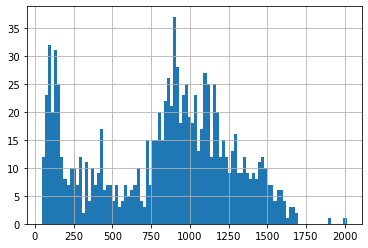

In [119]:
#check: target_value distribution in full dataframe looks same as original
df_plot[target_value].hist(bins=100)

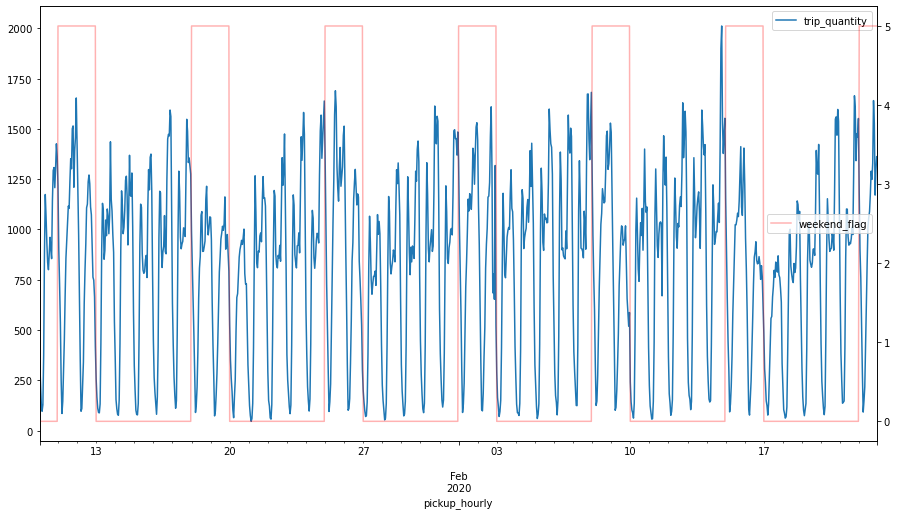

In [120]:
# EXAMPLE HOURLY RTS

# Visualize candidate RTS variables
plt.figure(figsize=(15, 8))
ax = plt.gca()
df_plot.plot(x=timestamp, y=target_value, ax=ax);
ax2 = ax.twinx()
df_plot.plot(x=timestamp, y='weekend_flag', color='red', alpha=0.3, ax=ax2);

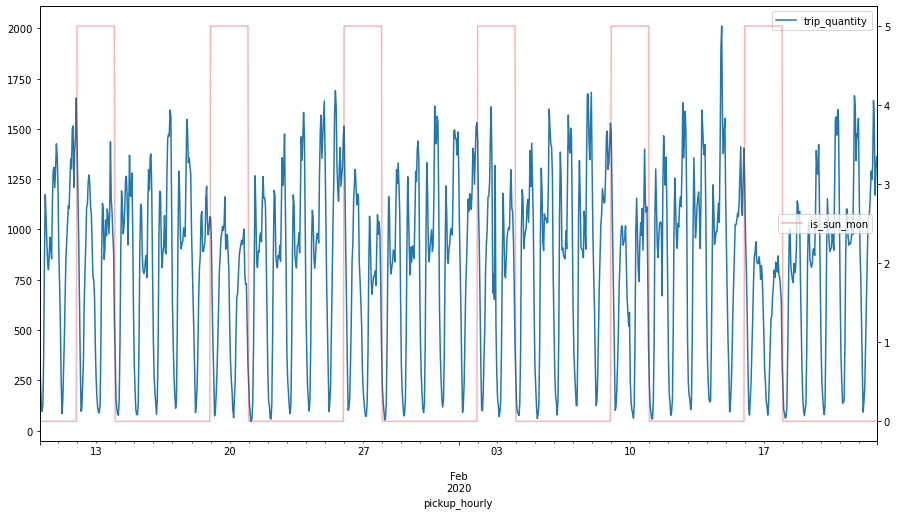

In [121]:
# EXAMPLE HOURLY RTS

# Visualize candidate RTS variables is_sun_mon
plt.figure(figsize=(15, 8))
ax = plt.gca()
df_plot.plot(x=timestamp, y=target_value, ax=ax);
ax2 = ax.twinx()
df_plot.plot(x=timestamp, y='is_sun_mon', color='red', alpha=0.3, ax=ax2);

It looks like lowest taxis rides are a combination of day and hour that seems to matter, not just day of week.

In [122]:
full_history.head(1)

,pulocationid,pickup_geolocation,pickup_hourly,trip_quantity,day_of_week,hour_of_day,day_hour_name,weekend_flag,is_sun_mon
0,1,40.68951565_-74.17678575,2019-07-01,0.00000,Monday,0,Monday_0,0,1


In [123]:
geolocation

'pickup_geolocation'

In [124]:
# EXAMPLE HOURLY RTS

# Assemble RTS - include whatever columns you finally decide
if geolocation is not None:
    rts = full_history[forecast_dims + [geolocation] + ['day_hour_name']].copy()
else:
    rts = full_history[forecast_dims + ['day_hour_name']].copy()

print(rts.shape)
print(rts.isnull().sum())
print(f"rts start: {rts[timestamp].min()}")
print(f"rts end: {rts[timestamp].max()}")
rts.sample(5)

(1522560, 4)
pickup_hourly         0
pulocationid          0
pickup_geolocation    0
day_hour_name         0
dtype: int64
rts start: 2019-07-01 00:00:00
rts end: 2020-02-29 23:00:00


,pickup_hourly,pulocationid,pickup_geolocation,day_hour_name
112520,2019-08-22 08:00:00,119,40.83673003_-73.92696621,Thursday_8
1469465,2020-02-13 17:00:00,90,40.74254616_-73.99677751,Thursday_17
3567,2019-11-26 15:00:00,1,40.68951565_-74.17678575,Tuesday_15
1151324,2019-11-25 20:00:00,41,40.80420483_-73.95206533,Monday_20
502822,2020-01-27 22:00:00,179,40.77142534_-73.92681236,Monday_22


In [125]:
# Save rts to S3
local_file = "rts.csv"
# Save merged file locally
rts.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.related.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)


In [126]:
EXPERIMENT_NAME

'nyctaxi_snap02232020_168H'

In [127]:
DATA_VERSION

1

In [128]:
prefix

'nyc-taxi-trips'

## Step 23. Assemble and save metadata (if any) <a class="anchor" id="IM"></a>

In [151]:
# Identify metadata columns
# im = df[[item_id, 'pickup_borough', 'binned_max_item']].copy()
im = df[[item_id, 'pickup_borough']].copy()
im = im.groupby(dims_except_timestamp).first()
im.reset_index(inplace=True)
# check nulls
display(im.isnull().sum())
im.sample(2)

pulocationid      0
pickup_borough    0
dtype: int64

,pulocationid,pickup_borough
15,115,Staten Island
1,10,Queens


In [152]:
# Additional metadata created by binning just item target_value is sometimes useful.

# aggregate sales by item 
synthetic = df.copy()
synthetic = (synthetic.groupby(item_id)
        .agg({target_value: ['max']}))

synthetic = synthetic.reset_index()
synthetic.sample(5)

#bin data into 4 categories
cat_scales = ["Cat_{}".format(i) for i in range(1,5)]
synthetic['item_cat_by_max'] = list(pd.cut(synthetic[target_value]['max'].values, 4, labels=cat_scales))

synthetic.drop(target_value, axis=1, inplace=True)
synthetic.columns = synthetic.columns.get_level_values(0)

print(synthetic.shape)
print(synthetic.dtypes)
print(synthetic.columns)
display(synthetic.sample(5))
print(synthetic.item_cat_by_max.value_counts(dropna=False))

# merge synthetic features
im = im.merge(synthetic, how="left", on=[item_id])
print(im.shape, synthetic.shape)
im.head()

(260, 2)
pulocationid       object
item_cat_by_max    object
dtype: object
Index(['pulocationid', 'item_cat_by_max'], dtype='object')


,pulocationid,item_cat_by_max
167,252,Cat_1
194,4,Cat_1
121,210,Cat_1
214,58,Cat_1
198,43,Cat_1


Cat_1    234
Cat_2     20
Cat_3      4
Cat_4      2
Name: item_cat_by_max, dtype: int64
(260, 3) (260, 2)


,pulocationid,pickup_borough,item_cat_by_max
0,1,EWR,Cat_1
1,10,Queens,Cat_1
2,100,Manhattan,Cat_1
3,101,Queens,Cat_1
4,102,Queens,Cat_1


In [153]:
# check metadata so far

print(im.shape)
if im.shape[0] < 50:
    display(im)
else:
    display(im.head())

# check cardinality of metadata columns
im.describe()

(260, 3)


,pulocationid,pickup_borough,item_cat_by_max
0,1,EWR,Cat_1
1,10,Queens,Cat_1
2,100,Manhattan,Cat_1
3,101,Queens,Cat_1
4,102,Queens,Cat_1


,pulocationid,pickup_borough,item_cat_by_max
count,260,260,260
unique,260,6,4
top,246,Queens,Cat_1
freq,1,69,234


In [154]:
# merge in sparse or not column
im['is_sparse'] = 0

im.loc[(im[item_id].isin(list(sparse[item_id].unique()))), 'is_sparse'] = 1
print(im.is_sparse.value_counts(dropna=False))
im.sample(5)

0    254
1      6
Name: is_sparse, dtype: int64


,pulocationid,pickup_borough,item_cat_by_max,is_sparse
47,144,Manhattan,Cat_2,0
70,165,Brooklyn,Cat_1,0
127,216,Queens,Cat_1,0
174,259,Bronx,Cat_1,0
197,42,Manhattan,Cat_1,0


In [155]:
# merge in top-moving or not column
im['top_moving'] = 0

im.loc[(im[item_id].isin(list(top_moving_items[item_id].unique()))), 'top_moving'] = 1
print(im.top_moving.value_counts(dropna=False))
im.sample(5)

0    213
1     47
Name: top_moving, dtype: int64


,pulocationid,pickup_borough,item_cat_by_max,is_sparse,top_moving
38,136,Bronx,Cat_1,0,0
223,66,Brooklyn,Cat_1,0,0
75,17,Brooklyn,Cat_1,0,0
24,123,Brooklyn,Cat_1,0,0
56,152,Manhattan,Cat_1,0,0


In [156]:
# merge in time series categories column
categories_df = full_history.groupby([item_id])[item_id, 'ts_type'].first()
categories_df.reset_index(inplace=True, drop=True)
# categories_df.head(2)

im = im.merge(categories_df, how="left", on=[item_id])
print(im.ts_type.value_counts(dropna=False))
im.sample(5)

smooth          213
erratic          43
intermittent      4
Name: ts_type, dtype: int64


,pulocationid,pickup_borough,item_cat_by_max,is_sparse,top_moving,ts_type
67,162,Manhattan,Cat_2,0,1,smooth
145,232,Manhattan,Cat_1,0,0,erratic
17,117,Queens,Cat_1,0,0,smooth
210,54,Brooklyn,Cat_1,0,0,smooth
83,177,Brooklyn,Cat_1,0,0,smooth


In [157]:
# Assemble metadata just columns you want

im = im.iloc[:, 0:3].groupby(item_id).max()
im.reset_index(inplace=True)
print(im.shape)
print("checking nulls..")
print(im.isnull().sum())
im.sample(5)

(260, 3)
checking nulls..
pulocationid       0
pickup_borough     0
item_cat_by_max    0
dtype: int64


,pulocationid,pickup_borough,item_cat_by_max
44,141,Manhattan,Cat_2
87,180,Queens,Cat_1
52,149,Brooklyn,Cat_1
55,151,Manhattan,Cat_1
231,73,Queens,Cat_1


In [158]:
# Save im to S3
local_file = "item_metadata.csv"
# Save merged file locally
im.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.metadata.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)